# Business Problem: 

Learn a buy signal from an already existing trading rule.

The current trading has a problem. The rule has more loses than wins. This is because the trading rules is set by if-else-then logic and these logic are very rigid. To understand this better, image a piece of cheese. of course,we only want the meat. The holes are analogy for failed trades while the meat represents the successfull trades. In this situation, we want our cheese to have at least 2/3 meat with maximum 1/3 holes.

We aim to capture a subset of the trading rule, whose logic is not based on static if-then-else statements but wit hMachine Learning.

![NN](cheese.jpg)


This is the current strategy is like this cheese. Got more holes that meat. 



## Feature Engineering:
All information from Foreign-Exchange providers are the same - the OHLC.
 - O -  open price for the period
 - H -  high price for the period
 - L -   low price for the period
 - C - close price for the period

These are the basic buildling blocks of our Fields. Unfortunately, we can't use these in their raw form. we need to mix and combine them - on certain relevant ways - that can help our Machine Learning Algorithm to create a rule. The following concepts are high introductions that we will use to Feature Engineer our fields ( columns )  

### Period
Each row of data (OHLC) is time-bound by a period. Period could be M1, M5, M15, H1, H4, D1, W or M. We will use the following for our dataset. 
 - M15 or 15-minute
 - H1 or 1-Hour period
 - H4 or 4-Hour period

### Stochastic Oscillator Formula

> %K = 100(C - L14)/(H14 - L14)
>
> Where:
> - C = the most recent closing price
> - L14 = the low of the 14 previous trading sessions
> - H14 = the highest price traded during the same 14-day period
> - %K= the current market rate for the currency pair
> - %D = 3-period moving average of %K

Read more: Stochastic Oscillator https://www.investopedia.com/terms/s/stochasticoscillator.asp#ixzz5S0c7KDgw 

### Bollinger Band
> A Bollinger Band is a set of lines plotted two standard deviations (positively and negatively) away from a simple moving average of the security's price. A Bollinger Band, developed by famous technical trader John Bollinger, is normally plotted two standard deviations away from a simple moving average but can be adjusted to user preferences.

Read more: Bollinger Band https://www.investopedia.com/terms/b/bollingerbands.asp#ixzz5S0efY97S 


### Fields / Columns
Our field will be Stochastic Osccillator detect momentum strength and Bollinger Band to detect direction at m15, h1 and h4. The idea is to capture the direction and strength of movement using these 2 indicators.

### Other Trading-related matters

This data is for EURUSD, which means the data is sensitive to European Euro and American Dollar. From trading class, EURUSD is sensitive to 3 news events: US NFP (Non-Farm Payroll) Report and ECB (European Central Bank) Interest Rate Decision and FOMC (Federal Open Market Committee) Interest Rate Decision. These 3 events are scheduled through-out the year with different intervals. ( NFP are release every 1st friday of the month while FOMC and ECB Interest Rate adjustment happens 8 times in a year). 

We include the Week number to factor in this information. We expect Week number to factor in the change in direction for mid-term to long term. Month / Day and Hour are to factor in the changes in the short - mid term. 

### Want column
This column is where some trading-related concepts is applied. A trade that is profitable with the proper Risk and Reward Ratio is the type of trades we want.  

![want](want_sample.jpg)

Sample of trades that are "True" 

## Exploratory Data Analysis

In [12]:
import pandas as pd                           # load pandas, numpy, seaborn and matplotlib for this project.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

DataScience = pd.read_csv('DataScience.csv')   # Read the data from the file.
DataScience.head()                             # see the headers of the data

,week,month,day,hour,stoch_m15,stoch_h1,stoch_h4,bband_m15,bband_h1,bband_h4,want
0,1,1,1,0,66.67,100.00,100.00,65.21,82.41,159.61,False
1,1,1,1,0,81.48,100.00,100.00,49.24,82.41,159.61,False
2,1,1,1,8,60.00,91.11,97.90,32.81,66.94,118.31,False
3,1,1,1,14,46.43,83.33,97.17,47.32,64.21,103.40,False
4,1,1,1,15,50.00,70.45,97.17,46.79,58.92,103.40,False


In [13]:
DataScience.shape

(435213, 11)

In [14]:
DataScience.columns.isnull().sum()                 # locate null points in all columns. None Seen.

0

In [15]:
DataScience.info()
# below is how the columns are suppose to be.
#week       // week number                            1 to 52
#month      // month number                           1 to 12
#hour       // hour of day                            0 to 23
#day        // day of the week                        0 to 7 - Monday to Sunday
#stoch_m15  // stochastic value at the m15 - 5,3,3    0 - 100
#stoch_h1   // stochastic value at the h1 - 5,3,3     0 - 100
#stoch_h4   // stochastic value at the h4 - 5,3,3     0 - 100
#bband_m15  // m15 bollinger band (20,0,2) value      0 - 150%?
#bband_h1   // h1  bollinger band (20,0,2) value      0 - 150%?
#bband_h4   // h4  bollinger band (20,0,2) value      0 - 150%?
#want       // target field for ML                    True / False

# Expected dytpes are correctly loaded.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435213 entries, 0 to 435212
Data columns (total 11 columns):
week         435213 non-null int64
month        435213 non-null int64
day          435213 non-null int64
hour         435213 non-null int64
stoch_m15    435213 non-null float64
stoch_h1     435213 non-null float64
stoch_h4     435213 non-null float64
bband_m15    435213 non-null float64
bband_h1     435213 non-null float64
bband_h4     435213 non-null float64
want         435213 non-null bool
dtypes: bool(1), float64(6), int64(4)
memory usage: 33.6 MB


In [16]:
DataScience.describe(include='all')             # let's check out our columns

,week,month,day,hour,stoch_m15,stoch_h1,stoch_h4,bband_m15,bband_h1,bband_h4,want
count,435213.00000,435213.000000,435213.000000,435213.000000,435213.000000,435213.000000,435213.000000,435213.000000,435213.000000,435213.000000,435213
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,391207
mean,26.48422,6.466195,2.990605,11.453674,50.234412,50.378678,50.790941,55.705812,57.714467,57.422285,NaN
std,14.94437,3.424949,1.410580,6.893196,33.392176,33.857653,35.178644,36.885891,37.377573,35.085463,NaN
min,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,13.00000,3.000000,2.000000,5.000000,18.750000,18.000000,16.020000,26.540000,28.940000,29.460000,NaN
50%,26.00000,6.000000,3.000000,11.000000,50.000000,50.480000,51.820000,50.850000,52.770000,54.760000,NaN
75%,39.00000,9.000000,4.000000,17.000000,81.820000,82.720000,85.460000,78.700000,80.480000,81.100000,NaN


 > __how come weeks got 53 ? there is something wrong with the Raw data __
 Current calculation of Epoch Week causes the week 53. This 'week' data needs to be re-think (on how to get) 
 
 __day is 1 to 5 only ? must comment that RAW data is of which timezone__
 Singapore +8GMT is Broker is +5GMT. 
 Broker closes at Friday 2359 (+5GMT) which is Singapore Sat 0259 (+8GMT)
 Broker Opens at Monday 0001 (+5GMT) which is Singapore Monday 0300 (+8 GMT)
 These opening and closing information are FYI only. They should not affect the data  

 > __bband has max out at 217% !__

In [17]:
mask = DataScience.duplicated(keep=False)          # create a mask for duplicated items
print (DataScience[mask])                          # apply the mask over the Data Set and display it.
DataScience[mask].shape                            # see the shape of the duplicated rows / samples

        week  month  day  hour  stoch_m15  stoch_h1  stoch_h4  bband_m15  \
4114       9      3    4    23      87.50     47.76    100.00       8.02   
4115       9      3    4    23      87.50     47.76    100.00       8.02   
8678      19      5    2    14       0.00     46.00      0.00      55.07   
8679      19      5    2    14       0.00     46.00      0.00      55.07   
11228     24      6    4     4     100.00     48.28     51.69      48.04   
11229     24      6    4     4     100.00     48.28     51.69      48.04   
11230     24      6    4     5     100.00     51.61     51.69      58.59   
11231     24      6    4     5     100.00     51.61     51.69      58.59   
13920     30      7    2     6       0.00     75.00     60.38      24.79   
13921     30      7    2     6       0.00     75.00     60.38      24.79   
14101     30      7    4     3     100.00     18.18    100.00       6.39   
14102     30      7    4     3     100.00     18.18    100.00       6.39   
17384     37

(104, 11)

In [18]:
DataScience.drop_duplicates(inplace=True)           # 52 entries were duplicate. they were dropped.
DataScience.shape                                   # final size is now 52 rows smaller.

(435161, 11)

Let's check our Target columns using describe. stoch_xx fields are as expected. 
We know for a fact that stoch_xx is a percentage value from 0-100. we can confirm from Min, Mean, 50%, Max that the scale is indeed from 0 - 100%.

In [19]:
DataScience.stoch_m15.describe()                         # let's check our target column

count    435161.000000
mean         50.234094
std          33.390028
min           0.000000
25%          18.750000
50%          50.000000
75%          81.820000
max         100.000000
Name: stoch_m15, dtype: float64

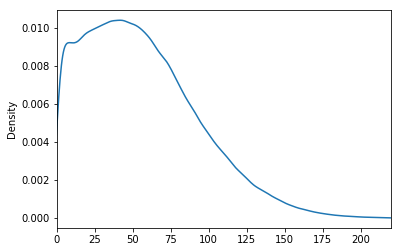

In [20]:
DataScience.bband_m15.plot(kind='density', xlim=(0, 220))

For bband_xxx there range is 0 - 200% but looks like this have a long tail toward the right.

In [21]:
DataScience.bband_h4.describe()                         # let's check our target column

count    435161.000000
mean         57.422497
std          35.085867
min           0.000000
25%          29.460000
50%          54.760000
75%          81.100000
max         205.130000
Name: bband_h4, dtype: float64

Panda's .describe() is practically useless for our targe column becues it is a 2-state True vs False thing. 

### EDA: do we need to do xxxxx?

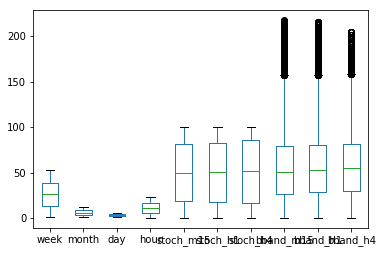

In [22]:
DataScience.drop('want', axis=1).plot(kind='box')           # plot only accepts numerical columns. We plot the feature columns
                                                            # no new information acquired.

all values range from 0 - 217. no need to xxxxx

In [23]:
DataScience.want.value_counts()                     # let's check our target column.

False    391161
True      44000
Name: want, dtype: int64

In [24]:
print ( 44000/(391161+44000))                       # 10.11% vs 89.88%

0.10111200222446405


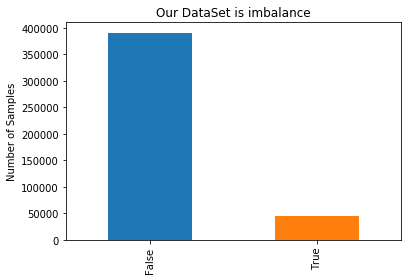

In [25]:
DataScience.want.value_counts().plot.bar()          #visuzlize the imbalance
plt.ylabel('Number of Samples')
plt.title('Our DataSet is imbalance')
plt.show()

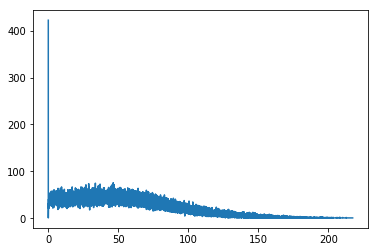

In [26]:
DataScience.bband_m15.value_counts().sort_index().plot()                ## does this tell me something? 
                                                                       # 417 times bband_m15 0s found?

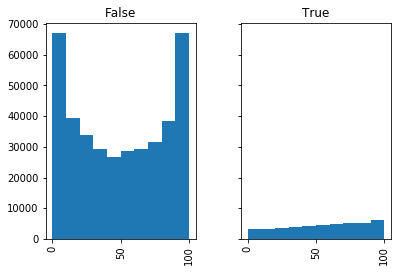

In [27]:
DataScience.hist(column='stoch_m15', by='want', sharey=True, sharex=True, layout=(1, 2))
plt.style.use('classic')

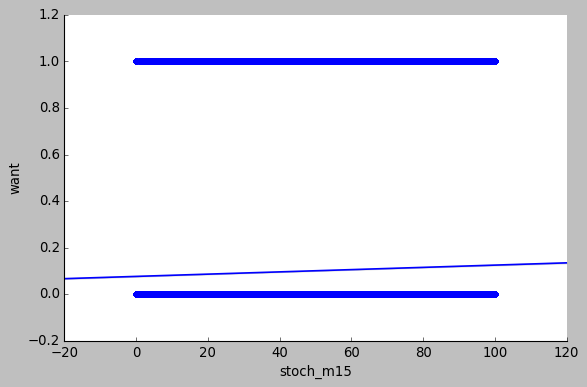

In [28]:
sns.lmplot(x='stoch_m15', y='want', data=DataScience, aspect=1.5, scatter_kws={'alpha':0.2})

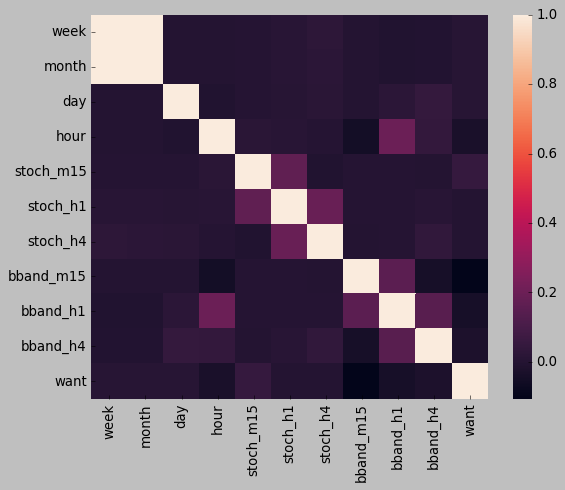

In [29]:
sns.heatmap(DataScience.corr())